In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
import xarray as xr

import common.loss_utils as loss_utils
import common.climatehack_dataset as climatehack_dataset 

import sys
sys.path.append('./dgmr_original')
import dgmr


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/test.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((2189,), (2189, 325, 400))

In [7]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366


In [8]:
torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
])

In [10]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, random_state=7):
        self.times = times
        self.data = data
        self.tsfm = tsfm
        self.generator = np.random.RandomState(random_state)
        
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(all_data)
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        # grab center crop
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [11]:
x, y = ds[0]

In [12]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

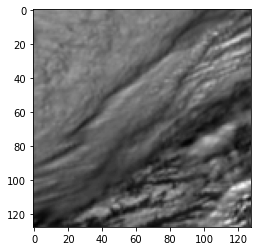

In [13]:
plt.imshow(x[-1], cmap='gray')

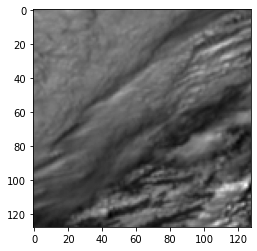

In [14]:
plt.imshow(y[0], cmap='gray')

In [21]:
# model = dgmr.DGMR(
#     forecast_steps=FORECAST,
#     input_channels=1,
#     output_shape=128,
#     latent_channels=384,
#     context_channels=192,
#     num_samples=3,
# )
# model = model.to(DEVICE)

ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=192,
)

lcs = dgmr.common.LatentConditioningStack(
    shape=(8 * 1, 128 // 32, 128 // 32),
    output_channels=384,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=384,
    context_channels=192,
)

model = dgmr.generators.Generator(ccs, lcs, sampler)
model.load_state_dict(torch.load('weights/dgmr_128_wd/tmp.pt'))
model = model.to(DEVICE)


In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 13399657 trainable parameters


In [23]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [24]:
model.eval()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)
for i, (srcs, trgs) in enumerate(pbar):
    x = srcs.float().to(DEVICE)
    y = trgs.float().to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    preds = []
    for _ in range(1):
        with torch.no_grad():
            p = model(x)
            preds.append(p)
    preds = torch.mean(torch.stack(preds, dim=0), dim=0)
        
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
#     preds[preds<0] = 0
#     preds[preds>1023] = 1023
    score = get_mssim(preds[:,:,:,32:96,32:96], y[:,:,:,32:96,32:96], average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')
        

  0%|          | 0/135 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Score: 0.7158645476180092: 100%|██████████| 135/135 [00:39<00:00,  3.42it/s]


In [25]:
scores = np.array(scores)
scores.mean()

0.7158645476180094

In [26]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.89171485, 0.84653879, 0.80747466, 0.78161493, 0.76255417,
       0.7474417 , 0.73435522, 0.72345313, 0.71365536, 0.70614781,
       0.69948656, 0.69380317, 0.68893108, 0.68465835, 0.6807589 ,
       0.67728242, 0.67438214, 0.67190502, 0.66966781, 0.66762167,
       0.66597927, 0.66480335, 0.66380082, 0.66271797])

In [38]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [39]:
choice = 6
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.7243690644702321

In [27]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

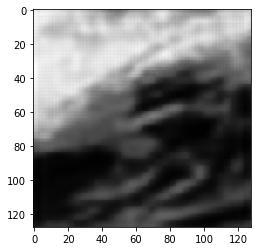

In [28]:
plt.imshow(out[0,0], cmap='gray')

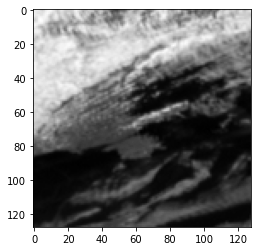

In [29]:
plt.imshow(true[0,0], cmap='gray')

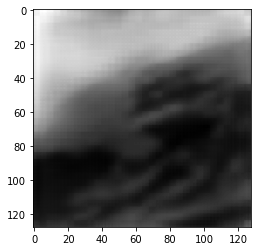

In [30]:
plt.imshow(out[0,-1], cmap='gray')

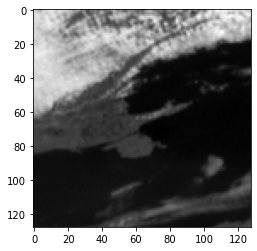

In [31]:
plt.imshow(true[0,-1], cmap='gray')